# 1. Problem Introduction

College students and young adults often face the challenge of balancing grocery budgets with a desire to try new, interesting recipes. Many stick to buying staple items and then add ingredients only when trying a new recipe. Our project aims to solve the question: how can students and young adults maximize exposure to diverse, advanced recipes while staying within their grocery budget?

This project focuses on developing a model to optimize grocery purchases within a given budget, B, to maximize the number of meals or recipes that can be prepared.  We define an advanced recipe to be one with at least seven ingredients, and the minimum number of recipes to be made from a set of purchased ingredients to be seven. Since there may be multiple solutions to the recipe maximization model given a budget, we then minimize the money spent on ingredients. Solving these two problems provides the cheapest set of ingredients that will make the maximum possible amount of recipes given a budget.

# 2. A description of the approach used.
To approach this problem, we required data on individual recipes and their respective ingredients, including associated prices. We identified a dataset on Kaggle containing hundreds of recipes from around the world. For ingredient pricing, we used data from the U.S. Bureau of Labor Statistics for core items such as onions, apples, potatoes, and beef. However, as the Bureau does not track prices for all ingredients, we supplemented the data using Instacart for any untracked items.

For modeling in Gamspy, we defined two primary sets:
- **I**: A one-dimensional array containing the names of ingredients (e.g., onion, beef).
- **R**: A one-dimensional array containing unique recipe IDs.

Using these sets, we modeled the relationships between recipes and ingredients with the following parameters:
- **K**:  A binary indicator matrix over sets R and I, where K(r,i)=1 indicates that recipe r includes ingredient i
- **A**:  A positive matrix where A(r,i) specifies the quantity of ingredient i used in recipe r (e.g., recipe r uses 1 lb of potatoes).
- **C**:  Specifies the cost of each ingredient.
- **B**:  Upper bound on the total expenditure on ingredients.

The model also included the following variables:
- **X**: An indicator variable indexed by R, denoting whether recipe r is selected.
- **Z**: A variable indexed by I, representing the amount of ingredient i to purchase. Since only whole amounts can be purchased, Z is an integer variable >= 0
- **L**: A variable representing the leftover quantity of ingredient i, which is penalized in the objective function using the L1 norm. L >= 0
With these variables and sets, the relationships between recipes, ingredients, and costs were mathematically modeled using the following equations to optimize the selection of recipes while minimizing waste and adhering to budget constraints.


# 3. An optimization model and its solution

## Initial Data Reading and Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

df = pd.read_csv('./recipe_data/ingredients_refined.csv')

ingredients = np.array(df['ingredient'].str.lower().values)
price = np.array(df['price'].values)
metric = np.array(df['metric'].values)

## Initial Data Processing for Amount Matrix, the Contains Matrix, and the Cuisine Matrix

In [2]:
import json
import pandas as pd 

with open('./recipe_data/augmented_recipes.json', 'r') as f:
    recipes = json.load(f)

# Create a DataFrame to store the quantity of each ingredient per recipe
# Columns are ingredient names; rows are indexed by recipe IDs
matrix_recipe_ingredients = pd.DataFrame(columns=ingredients, index=[recipe['id'] for recipe in recipes])
# Strip any leading/trailing whitespace from column names
matrix_recipe_ingredients.columns = matrix_recipe_ingredients.columns.str.strip()

# Create another DataFrame to indicate presence (1) or absence (0) of ingredients in recipes
matrix_recipe_contains = pd.DataFrame(columns=ingredients, index=[recipe['id'] for recipe in recipes])
matrix_recipe_contains.columns = matrix_recipe_contains.columns.str.strip()

# Initialize a set to collect all unique cuisine types
cuisines = set()

# Iterate over each recipe to populate the matrices
for recipe in recipes:
    # Add the cuisine type to the set of cuisines
    cuisines.add(recipe['cuisine'])
    
    # For each ingredient and its corresponding quantity in the recipe
    for ingredient, quantity in zip(recipe["ingredients"], recipe["quantities"]):
        ingredient = ingredient.strip().lower()  # Clean up ingredient name
        
        exact_match = False
        
        # Try to find an exact match for the ingredient in the columns
        for column in matrix_recipe_ingredients.columns:
            if ingredient == column:
                matrix_recipe_ingredients.loc[recipe["id"], column] = quantity  # Record the quantity
                matrix_recipe_contains.loc[recipe["id"], column] = 1  # Mark presence
                exact_match = True
        
        # If no exact match, try partial match (ingredient is a substring of a column)
        if not exact_match:
            for column in matrix_recipe_ingredients.columns:
                if ingredient in column: 
                    matrix_recipe_ingredients.loc[recipe["id"], column] = quantity  # Record quantity for closest match
                    matrix_recipe_contains.loc[recipe["id"], column] = 1  # Mark presence
                    break  # Stop after the first match

# Create a DataFrame to map each recipe to its cuisine
matrix_cuisine_recipe = pd.DataFrame(columns=list(cuisines), index=[recipe['id'] for recipe in recipes])

# Populate the cuisine-recipe matrix
for recipe in recipes:
    cuisine = recipe['cuisine']
    matrix_cuisine_recipe.loc[recipe["id"], cuisine] = 1  # Mark 1 for the corresponding cuisine

# Replace all NaN values with 0s for clean matrices
matrix_recipe_ingredients = matrix_recipe_ingredients.fillna(0)
matrix_cuisine_recipe = matrix_cuisine_recipe.fillna(0)
matrix_recipe_contains = matrix_recipe_contains.fillna(0)


/var/folders/j8/1bvzgm4101s7j3gvky9rf0mr0000gn/T/ipykernel_66661/1835470954.py:55: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix_recipe_ingredients = matrix_recipe_ingredients.fillna(0)
/var/folders/j8/1bvzgm4101s7j3gvky9rf0mr0000gn/T/ipykernel_66661/1835470954.py:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix_cuisine_recipe = matrix_cuisine_recipe.fillna(0)
/var/folders/j8/1bvzgm4101s7j3gvky9rf0mr0000gn/T/ipykernel_66661/1835470954.py:57: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will ch

## Model Definition

### Set definitions

In [3]:
import gamspy as gp
import numpy as np
import gamspy.math as gpm

cont = gp.Container()
I = cont.addSet('I', records = [ingredients[idx] for idx in range(len(ingredients))], description = 'A set containing all of the valid ingredients')
R = cont.addSet('R', records = [recipe['id'] for recipe in recipes], description= 'A set containing all of the recipes that can be made')
S = cont.addSet('S', records = [1/15, 1/10, 1/5, 1/4, 1/2, 1], description="Sizes of ingredients purchasable")
Cuisines = cont.addSet('Cuisines', records = [i for i in cuisines], description = 'Different cuisines')

### Parameter Definitions

In [4]:
PPS = cont.addParameter('PPS', domain=[S], description="Price per size scalar",
                        records=np.array([[1/15], [1/10], [1/5], [1/4], [1/2], [1]]))
APS = cont.addParameter('APS', domain=[S], description="Unit amount per size scalar",
                        records=np.array([[1/15], [1/10], [1/5], [1/4], [1/2], [1]]))

C = cont.addParameter('C', domain=[S, I], description="Cost per unit of each of the ingredients",
                      records = np.expand_dims(PPS.records['value'].to_numpy(), axis=0).T * np.tile(price, (6,1)))

A = cont.addParameter('A', domain=[R, I], description="Amount of ingredient i required in recipe r", records = np.array(matrix_recipe_ingredients))
B = cont.addParameter('B', description="Budget to purchase ingredients", records=63)

Contains = cont.addParameter('contains', domain = [R, I], description = 'Binary matrix indicating that recipe r contains ingredient i', records = np.array(matrix_recipe_contains))

### Variable Definitions

In [5]:
z = cont.addVariable('z', "integer", domain=[S, I], description="Amount of ingredient i purchased")
x = cont.addVariable('x', "binary", domain=[R], description="Indicator variable to make recipe r")
l = cont.addVariable('l', "free", domain=[I], description="Leftover ingredients after all recipes are made")
m = cont.addVariable('m', 'free', description="money spent")

### Equations

In [6]:
budget = cont.addEquation('budget', 'regular',
                        description="Constrains the total money spent on ingredients to be within the budget")
budget[:] = gp.Sum([S,I], C[S,I] * z[S,I]) <= B

ingredient_amounts = cont.addEquation('ingredient_amounts', 'regular', domain=[I],
                              description="Ensures enough ingredients are purchased to satisfy the selected recipes")
ingredient_amounts[I] = gp.Sum(R, A[R, I] * x[R]) <= gp.Sum(S, APS[S] * z[S, I])

waste = cont.addEquation('waste', 'regular', domain=[I],
                          description="Sets the leftover variable equal to the amount of unused ingredients")
waste[I] = l[I] == gp.Sum(S, APS[S] * z[S, I]) -  gp.Sum(R, A[R, I] * x[R])

tot_recipes = cont.addEquation('tot_recipes', description="Ensures enough recipes for a weeks worth of dinner can be made")
tot_recipes[:] = gp.Sum(R, x[R]) >= 7

contains_recipe = cont.addEquation('contains_recipe', description="Ensures only selecting recipes with greater than 7 ingredients", domain = [R])
contains_recipe[R] = x[R] * gp.Sum(I,Contains[R, I]) >= 7 * x[R]

money_spent = cont.addEquation('money_spent', 'regular')
money_spent[:] = m == gp.Sum([S,I], C[S,I] * z[S,I])

z.lo[S, I]= 0
l.lo[:] = 0

In [7]:
objective = gp.Sum(R, x[R]) 

recipe_optimization = cont.addModel(
    name='recipe_optimization',
    problem=gp.Problem.MIP,
    equations=cont.getEquations(),
    sense=gp.Sense.MAX,
    objective=objective
)

## Model Execution

We first solve a single instance when the budget is $56. Later, during our sensitivity study, we will exand upon the scenarios in which this model is run. For now, we are maximizing the amount of recipes that can be made with a budget of 56.

In [8]:
B.setRecords(56)
recipe_optimization.solve(options=gp.Options(time_limit= 10))

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,12,386,1092,MIP,CPLEX,0.075


Here we display the amount of ingredients purchased, how much money is spent, and the number of recipes that can be made

In [9]:
df = z.records
print(f"Amount of ingredients to purchase: {len(df[df['level'] > 0])}")
print(f"Money Spent {m.records['level'][0]}")
print(f"Recipes: {recipe_optimization.objective_value}")

Amount of ingredients to purchase: 60
Money Spent 55.93286666666669
Recipes: 12.0


Now that we have the maximum number of recipes that can be made within our budget, we enforce that thus number of recipes will be made and minimize the amount spent. To do this, we create a new modle with an additional equation that minimizes over a slightly different objective than the first.

In [10]:
max_recipe_eq = cont.addEquation('max_recipe_eq', description="The maximum number of recipes that can be made given the budget")
max_recipe_eq[:] = gp.Sum(R, x[R]) == recipe_optimization.objective_value

money_optimization = cont.addModel(
    name='money_optimization',
    problem=gp.Problem.MIP,
    equations=cont.getEquations(),
    sense=gp.Sense.MIN,
    objective=m
)
money_optimization.solve()


,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,55.5762333333333,387,1092,MIP,CPLEX,0.072


Here we display how many ingredients are now purchased as well as the money spent. Again 15 recipes are made, but less money is spent on ingredients.

In [11]:
df = z.records
print(f"Amount of ingredients to purchase: {len(df[df['level'] > 0])}")
print(f"Money Spent {m.records['level'][0]}")
print(f"Recipes: {recipe_optimization.objective_value}")

Amount of ingredients to purchase: 66
Money Spent 55.57623333333334
Recipes: 12.0


Now we visualize the ingredients purchased to give us a better insight into what was bought and how much. It is important to note that the y-scale is pricing units. This means that 1 unit of salt (measured in ounces) is not the same amount as one unit of steak (measured in pounds).

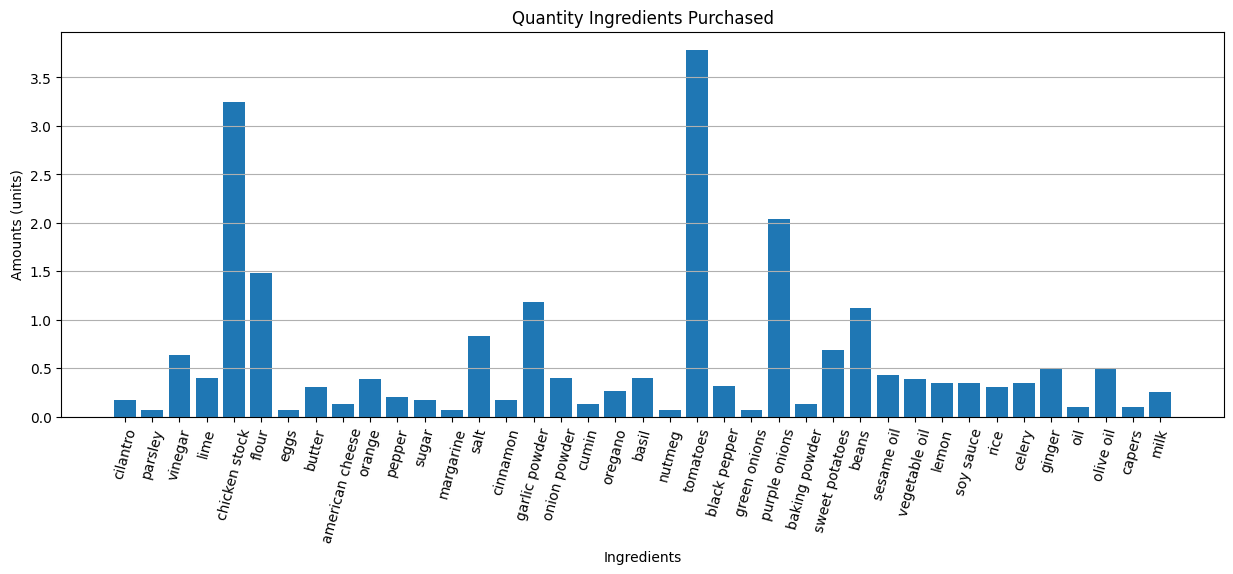

In [12]:
purchased = {}
for item, scale, i in zip(z.records[z.records['level'] > 0]['level'], z.records[z.records['level'] > 0]['S'], z.records[z.records['level'] > 0]['I']):
    if i in purchased:
        purchased[i] = purchased[i] + float(item)*float(scale)
    else:
        purchased[i] = float(item)*float(scale)
        
matplotlib.rcParams['figure.figsize'] = [15, 5]
plt.grid(which='both', axis='y')
plt.bar(purchased.keys(),purchased.values(), width=0.8)
plt.xticks(rotation=75)
plt.xlabel('Ingredients')
plt.ylabel('Amounts (units)')
plt.title('Quantity Ingredients Purchased')

plt.show()

In [13]:
print(f"Recipes to make: \n{x.records[x.records['level'] > 0]['R']}")

Recipes to make: 
13     31318
14     31027
20     27858
54     21467
72     14080
75     47427
83     16810
87     14970
92     29734
107     7528
119    22678
123    20983
Name: R, dtype: category
Categories (124, object): ['10259' < '25693' < '20130' < '6602' ... '428' < '6745' < '31009' < '20983']


Now we visualize the ingredients required for a particular recipe that was chosen by the model to be made.

Text(0.5, 1.0, 'Ingredients for Recipe 31318')

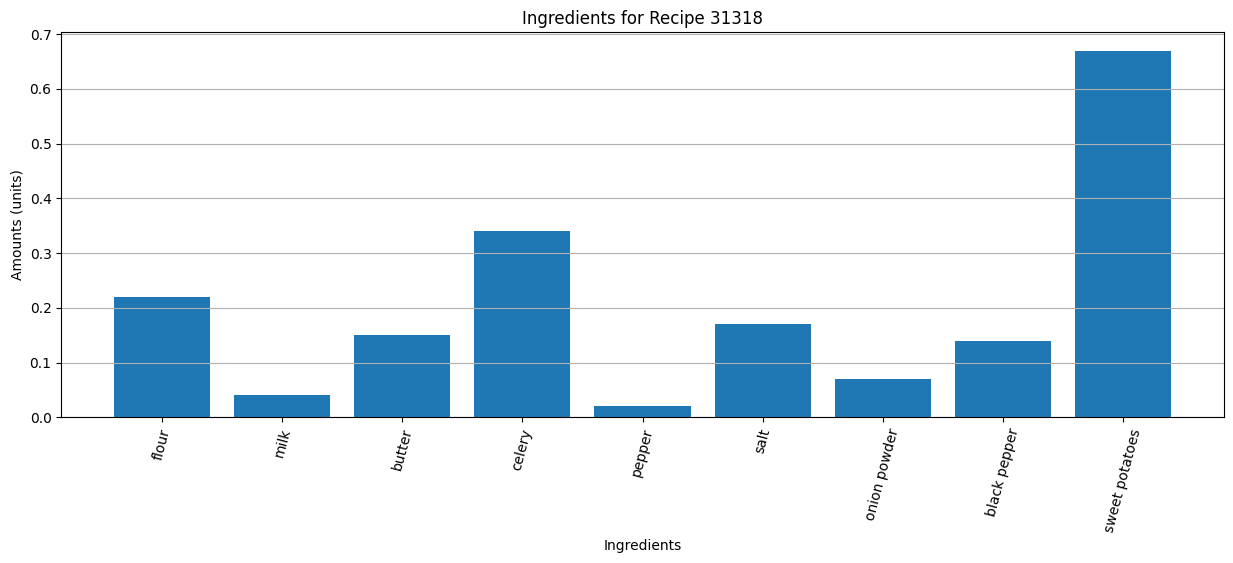

In [14]:
plt.grid(which='both', axis='y')
plt.bar(A['31318', :].records['I'].values,A['31318', :].records['value'].values, width=0.8)
plt.xticks(rotation=75)
plt.xlabel('Ingredients')
plt.ylabel('Amounts (units)')
plt.title('Ingredients for Recipe 31318')

## Model Variations

After looking at the above recipe, one thing is clear: maximizing total recipes and then minimizing for cost means we probably won't get recipies with more expensive ingredients like steak or salmon. We can modify the model, however, so that at least one recipe uses these ingredients. The following cells establish this model variation and solve for a new set of recipes. Additionally, since these ingredients are more expensive, we will be increasing the budget for this problem.

In [15]:
steak = cont.addEquation('steak', description="Ensures that a one recipie contains steak")
steak[:] = gp.Sum(R, x[R] *  Contains[R, 'steak']) >= 1

salmon = cont.addEquation('salmon', description="Ensures one recipie contains salmon")
salmon[:] = gp.Sum(R, x[R] *  Contains[R, 'salmon']) >= 1

chicken = cont.addEquation('chicken', description="Ensures that two recipies contain chicken breasts")
chicken[:] = gp.Sum(S, APS[S] * z[S, 'chicken breast']) >= 1

model_variation = cont.addModel(
    name='recipe_optimization',
    problem=gp.Problem.MIP,
    equations=[budget, ingredient_amounts, waste, tot_recipes, contains_recipe, money_spent, steak, salmon, chicken],
    sense=gp.Sense.MAX,
    objective=gp.Sum(R, x[R]) 
)

Notice that the total number of recipes that can be made has been reduced as a result of forcing the above quantities to be in the recipies. This happens because steak, salmon, and chicken cost more than other ingredients like potatoes. Thus, they are not optimal to purchase when maximizing for total recipies.

In [16]:
B.setRecords(77)
model_variation.solve(solver='cplex', options=gp.Options(time_limit=10))

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,10,389,1092,MIP,CPLEX,0.047


In [17]:
print(f"Total money spent: {m.records['level'][0]}")

Total money spent: 76.93188333333335


We again visualize the ingredients purchase. Notice now the red bars indicating the sources of protien required from the new equations in this model variation. They all satisfy the equality portion of the inequalities. This again comes down to the fact that they are more expensive than other ingredients. Thus, it is not optimal to buy even more of them as that money could be spent on other cheaper recipies.

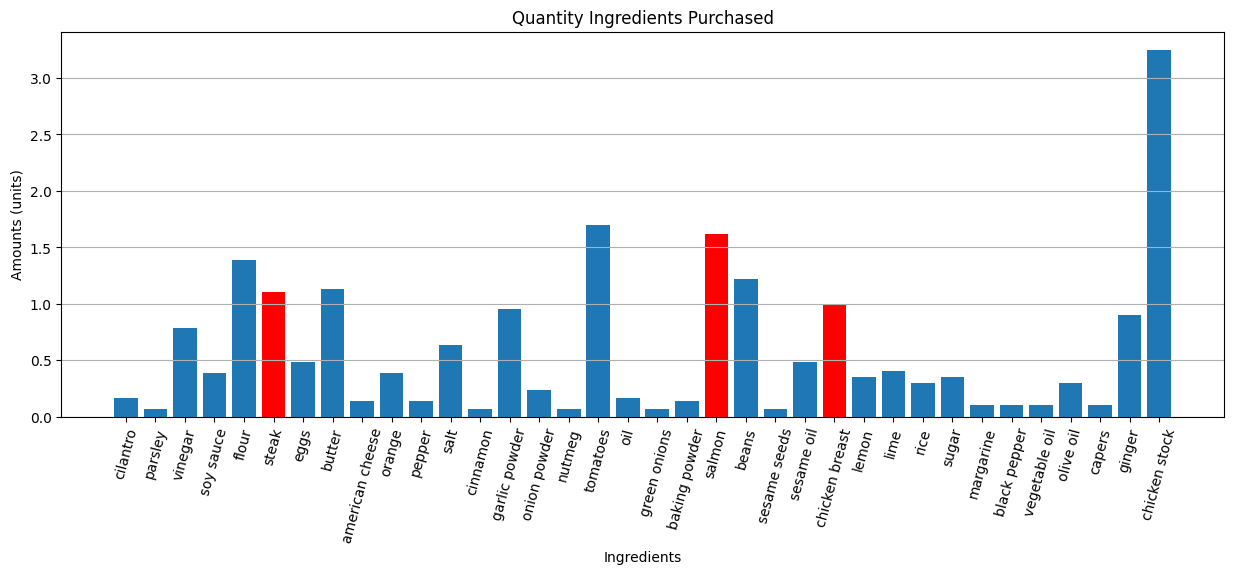

In [18]:
purchased = {}
for item, scale, i in zip(z.records[z.records['level'] > 0]['level'], z.records[z.records['level'] > 0]['S'], z.records[z.records['level'] > 0]['I']):
    if i in purchased:
        purchased[i] = purchased[i] + float(item)*float(scale)
    else:
        purchased[i] = float(item)*float(scale)

matplotlib.rcParams['figure.figsize'] = [15, 5]
plt.grid(which='both', axis='y')
plt.bar(purchased.keys(),purchased.values(), width=0.8)
plt.bar(['steak', 'salmon', 'chicken breast'], [purchased['steak'], purchased['salmon'], purchased['chicken breast']], width=0.8, color='red')
plt.xticks(rotation=75)
plt.xlabel('Ingredients')
plt.ylabel('Amounts (units)')
plt.title('Quantity Ingredients Purchased')

plt.show()

In [19]:
print(f"Recipes to make: \n{x.records[x.records['level'] > 0]['R']}")

Recipes to make: 
14     31027
30     25751
54     21467
72     14080
75     47427
87     14970
92     29734
102     1355
107     7528
123    20983
Name: R, dtype: category
Categories (124, object): ['10259' < '25693' < '20130' < '6602' ... '428' < '6745' < '31009' < '20983']


Text(0.5, 1.0, 'Ingredients for Recipe 25751')

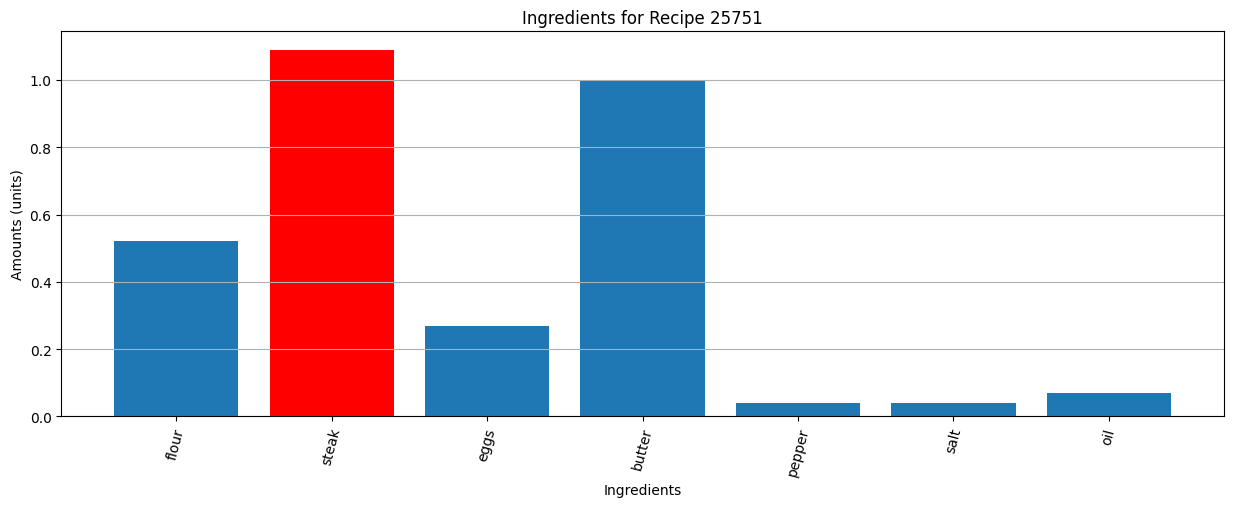

In [20]:
recipie_id = '25751'
plt.grid(which='both', axis='y')
plt.bar(A[recipie_id, :].records['I'].values,A[recipie_id, :].records['value'].values, width=0.8)
plt.bar('steak',A[recipie_id, :].records['value'].values, width=0.8, color='red')
plt.xticks(rotation=75)
plt.xlabel('Ingredients')
plt.ylabel('Amounts (units)')
plt.title(f'Ingredients for Recipe {recipie_id}')

# 4. Processing and Analysis

## Budget Sensitivity Analysis
Here we analyze how sensative our model is to changes in parameters. In this case, we vary the budget and compare the amount of money spent and the amount of recipies made to optimizations under other budgets.

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt 

amount_recipes_m1 = []
amount_recipes_m2 = []
budget = []
loss = []
money_spent_m1 = []
money_spent_m2 = []


for num in range(50, 250):
    B.setRecords(num)
    recipe_optimization.solve(solver = 'cplex', options=gp.Options(time_limit=20))

    df = x.records
    money_spent_m1.append(m.records['level'])
    number_recipes = len(df[df['level'] > 0])
    amount_recipes_m1.append(number_recipes)

    max_recipe_eq[:] = gp.Sum(R, x[R]) == recipe_optimization.objective_value
    money_optimization.solve(solver = 'cplex', options=gp.Options(time_limit=20))

    df = x.records
    number_recipes2 = len(df[df['level'] > 0])
    loss.append(l.records['level'].sum())
    budget.append(num)
    amount_recipes_m2.append(number_recipes2)
    money_spent_m2.append(money_optimization.objective_value)
    
    if num % 10 == 0:
        print(f'Budget = {num}')


Budget = 50
Budget = 60
Budget = 70
Budget = 80
Budget = 90
Budget = 100
Budget = 110
Budget = 120
Budget = 130
Budget = 140
Budget = 150
Budget = 160
Budget = 170
Budget = 180
Budget = 190
Budget = 200
Budget = 210
Budget = 220
Budget = 230
Budget = 240


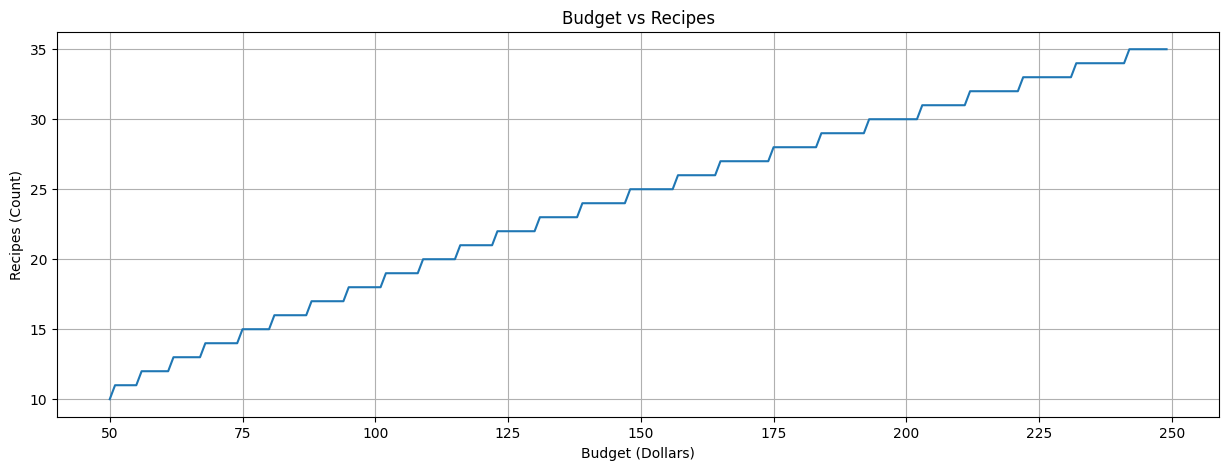

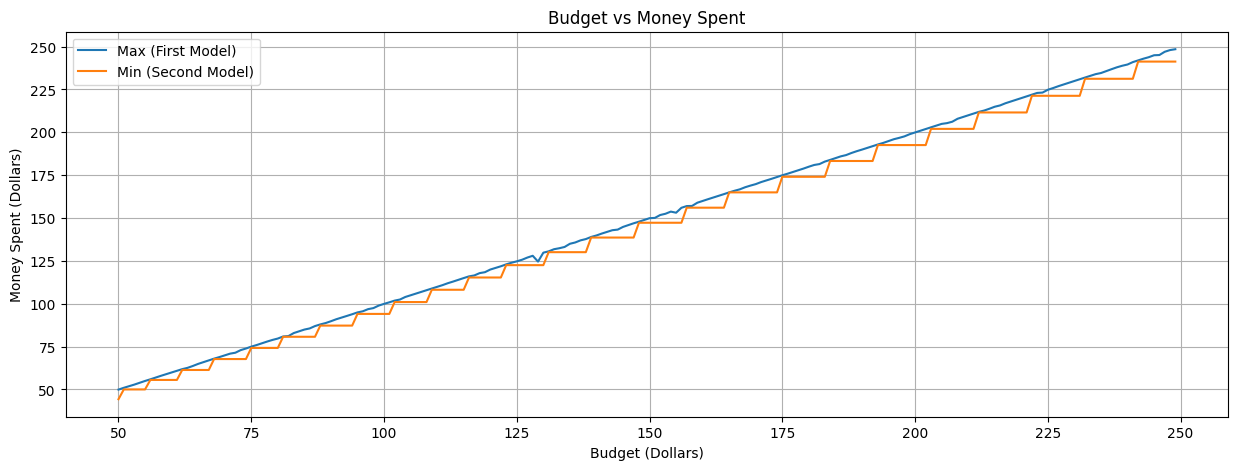

In [22]:
import seaborn as sns

sns.lineplot(x = budget, y = amount_recipes_m1)
plt.title('Budget vs Recipes')
plt.xlabel('Budget (Dollars)')
plt.ylabel('Recipes (Count)')
plt.grid()
plt.show()

sns.lineplot(x = budget, y = [money[0] for money in money_spent_m1],legend='brief', label='Max (First Model)')
sns.lineplot(x = budget, y = money_spent_m2, legend='brief', label='Min (Second Model)')
plt.title('Budget vs Money Spent')
plt.xlabel('Budget (Dollars)')
plt.ylabel('Money Spent (Dollars)')
plt.grid()

Notice that as the budget increases, the amount it takes to make an additional recipie also increases. This makes logical sense as we initially make the cheapest recipies. As these recipies begin to run out, it will cost more to increment the amount of recipies made.

## Price Sensitivity Analysis
In this scenario, we simulate a shortage of tomatoes (an item shown to be essential to many recipies earlier in the bar chart). Since there is a shortage, the price will increase. We analyze how the quantities of other ingredients purchased changes as the price of tomatoes is varried. We also track the difference in the number of recipies made as this price increases.

In [23]:
money_spent_m1=[]
amount_recipes_m1=[]
budget=[]
amount_recipes_m2=[]
money_spent_m2=[]
ks = ['chicken stock','flour', 'milk', 'butter', 'salt',  'black pepper', 'sweet potatoes',   'rice',  'oil',  'tomatoes']
idx = 1

items = {}
for num in np.linspace(2, 6, 25):
    for size in [1/15, 1/10, 1/5, 1/4, 1/2, 1.0]:
        C[str(size), 'tomatoes'] = num

    recipe_optimization.solve(solver = 'cplex', options=gp.Options(time_limit=20))
    for k in ks:
        if k not in items:
            items[k] = [sum(z.records[z.records['I'] == k]['level'].to_numpy() * np.array([1/15, 1/10, 1/5, 1/4, 1/2, 1.0]))]
        else:
            items[k].append(sum(z.records[z.records['I'] == k]['level'].to_numpy() * np.array([1/15, 1/10, 1/5, 1/4, 1/2, 1.0])))
    df = x.records
    money_spent_m1.append(m.records['level'])
    number_recipes = len(df[df['level'] > 0])
    amount_recipes_m1.append(number_recipes)

    max_recipe_eq[:] = gp.Sum(R, x[R]) == recipe_optimization.objective_value
    money_optimization.solve(solver = 'cplex', options=gp.Options(time_limit=30))

    df = x.records
    number_recipes2 = len(df[df['level'] > 0])
    budget.append(num)
    amount_recipes_m2.append(number_recipes2)
    money_spent_m2.append(money_optimization.objective_value)
    
    idx+=1
    if idx % 5 == 0:
        print(f'Cost = {num}')

Cost = 2.5
Cost = 3.333333333333333
Cost = 4.166666666666666


[MODEL - WARNING] The solve was interrupted! Solve status: ResourceInterrupt. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.


Cost = 5.0
Cost = 5.833333333333333


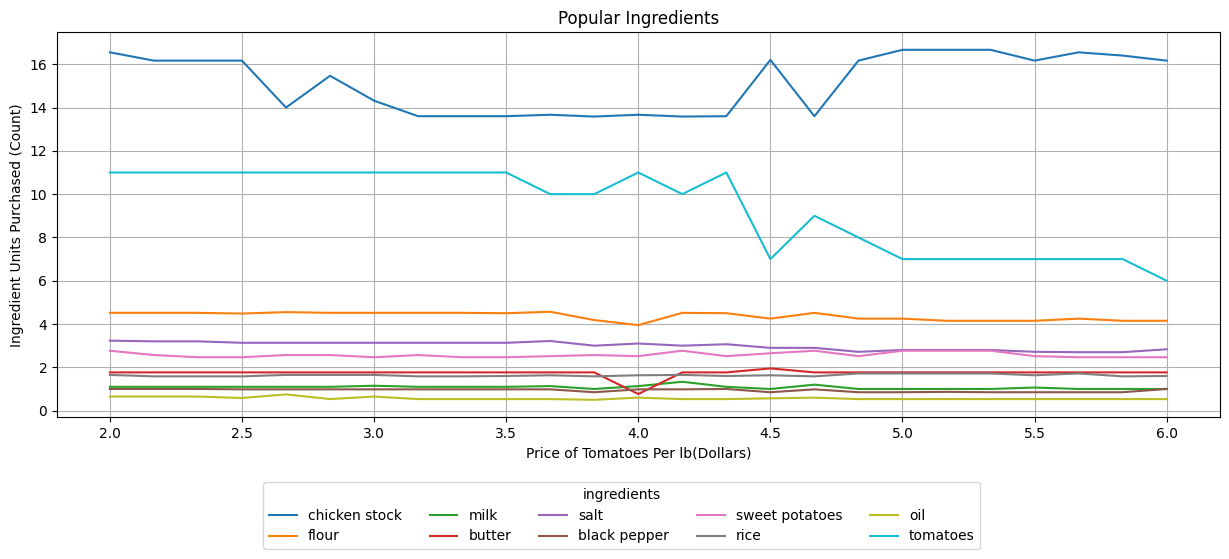

In [24]:
for i in items.keys():
    sns.lineplot(x=budget, y=items[i], legend='brief',label=i)
plt.title('Popular Ingredients')
plt.xlabel('Price of Tomatoes Per lb(Dollars)')
plt.ylabel('Ingredient Units Purchased (Count)')
plt.legend(title="ingredients",bbox_to_anchor=(.8, -.15),ncol=5)
plt.grid()
plt.show()

Notice that even as the price increases, the amount of tomatoes only decreases a small amount. It is still a prominent component of the purchased ingrdients. We can also see that as tomatoes decrease, we begin to purchase more chicke stock.

# 5. Conclusion

The variation of the model where steak, salmon, and chicken are required in the recipies provides for a well balanced diet. With a reasonable college-student budget of $77, the following recipie IDs should be made 1027, 25751, 21467, 14080, 47427, 14970, 29734, 1355, 7528, 20983. The specifics of these recipies can be found in augmented_recipes.json. Additionally, the model specified the quantities of each ingredient that should be purchased so that all of these recipies can be made. 

While this analysis was performed on static data, grocery prices fluctuate constantly. The sensitivity analysis on an increase of tomatoe prices showed that under relatively small price changes, the amounts of ingredients that should be purchased roughly stays the same. This is good news for consumers and college students because the recomendation from the model will likely stay close enough to the actual minimum as store prices change. This conclusion is additionally supported by the 'steps' that formed in the graph from the budget sensitivity study. The shape of this plot indicates that minor increases in the budget often do not change the total number of recipies that can be made. We can think of the increase in price of tomatoes as similarly small decrease in price in budget. Thus, small price fluctuations often have a similarly small affect of the rest of grocery purchases.

Analysing the budget sensitivity graph shows us that a single dollar does not have much effect on how many meals can be made. This logically makes sense as spending $74 vs $75 at the grocery store gets you roughly the same items. Of course, once the budget has been increased enough to purchase a new item or items, then new recipies can be made. When looking at how much more money is needed in the budget before the total number of recipies increases, we find that this value increases with each incrment in the number of recipies. As the cheapest recipies are fulfilled first, we are left with increasingly expensive recipies. Thus the amount of change required in the budget to make an additional recipie reflects this.

From building this model and analysing the results, we were able to draw three importat conclusions. First we found an optimal set of recipies to cook and ingredients to buy when shopping on a budget but also requiring some protien options. We also found that fluctuations in the prices of ingredients usually has small effects on what is considered optimal to purchase. And lastly, we found that minor increases to the budget do not lead to additional recipies, and that the increase required to make an additional recipie grows as the budget grows.

# 6. Extensions

This project can be extended for implementation across individual grocery store catalogs in online shopping platforms. With many consumers seeking to maximize financial efficiency, this approach offers a valuable tool to help them achieve their goals while introducing them to new products. <br/>
<br/>
Furthermore, the current model can be optimized for better performance. Grocery catalogs typically contain hundreds of items, if not thousands. While our model currently handles smaller dataset (~150 ingredients) efficiently, it struggles when processing datasets with more than 200 ingredients. By adopting a more efficient modeling approach, we can reduce runtime and enhance the model’s scalability, making it more practical and appealing for grocery stores to integrate into their online catalog systems.